<p>
    <strong>Idea</strong>: Combine <a href="https://arxiv.org/pdf/1802.03916.pdf">BBSE (Lipton et al ICML '18)</a> with <a href="https://arxiv.org/pdf/2007.08479.pdf">MALLS' (Zhao et al AISTATS '21)</a> subsampling technique while using <a href="http://proceedings.mlr.press/v70/finn17a/finn17a.pdf">MAML (Finn et al ICML '17)</a> to reduce bias in importance sampling weights learned from medial distribution and focus on domain adaptation on label shift.
</p>

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

import tqdm
import math
import time
from collections import Counter, deque, OrderedDict

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

from model import Network
from maml import MAML

In [2]:
#set reproducibility
np.random.seed(0)
_ = torch.manual_seed(0)

In [3]:
X, y = load_digits(return_X_y=True) #multiclassification

In [4]:
test_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)

## Create Imbalanced Dataset

In [5]:
def group_by_label(y):
    """ Groups data by label and returns indices per label """
    label_dict = {}
    for i in range(len(y)):
        if y[i] in label_dict:
            label_dict[y[i]].append(i)
        else: 
            label_dict[y[i]] = [i]
        
    return dict(OrderedDict(sorted(label_dict.items())))

In [6]:
def dirichlet_distribution(alpha, idx_by_label, size, no_change=False):
    """ Create Imbalanced data using dirichlet distribution """
    class_composition = np.array([len(idx_by_label[k]) for k in sorted(idx_by_label.keys())], np.int64)
    print("Original Class composition: ", class_composition)
    
    if no_change:
        dataset = []
        for v in idx_by_label.values():
            dataset += v
        return dataset
    
    distribution = np.random.dirichlet([alpha]*len(idx_by_label), size=())
    idx_by_label = idx_by_label.copy()
    
    
    #Group data by label
    for label in idx_by_label:
        class_size = math.ceil(size * distribution[label])
        if not class_size:
            class_size = 1 #min number to support A.2 assumption (BBSE ICML '18)
        indices = np.random.randint(0,
                                   len(idx_by_label[label]),
                                   size=(class_size, ))
        idx_by_label[label] = np.unique([idx_by_label[label][i] for i in indices]).tolist()
    
    class_composition = np.array([len(idx_by_label[k]) for k in sorted(idx_by_label.keys())], np.int64)
    print("Shifted Class composition: ", class_composition)
        
    #Build new dataset of indices
    dataset = []
    for v in idx_by_label.values():
        dataset += v
    return dataset #shifted distribution

In [7]:
def get_distribution(labels):
    """ Returns the distribution of classes as ratios """
    dist = dict(Counter(labels))
    total_size = 0
    for key, value in dist.items():
        total_size += value
    
    for key in dist:
        dist[key] /= total_size
        
    return dict(OrderedDict(sorted(dist.items())))

In [8]:
idx_by_label = group_by_label(y_train) #label : [indices of all labels]

In [9]:
train_ratio = 1
data_cap = int(2 * X_train.shape[0])
size = int(data_cap * (train_ratio / (train_ratio + 1)))

In [10]:
shifted_dist_idx = dirichlet_distribution(alpha=0.5, idx_by_label=idx_by_label, size=size, no_change=False)

Original Class composition:  [145 154 144 149 135 135 146 145 144 140]
Shifted Class composition:  [ 52  59  30  35 102  53   1   1  98 140]


In [11]:
#### Imbalanced test dist.
idx_by_label = group_by_label(y_test) #label : [indices of all labels]

In [12]:
test_ratio = 1
data_cap = int(2 * X_test.shape[0])
size = int(data_cap * (test_ratio / (test_ratio + 1)))

In [13]:
shifted_test_dist_idx = dirichlet_distribution(alpha=0.5, idx_by_label=idx_by_label, size=size, no_change=False)

Original Class composition:  [33 28 33 34 46 47 35 34 30 40]
Shifted Class composition:  [ 4 12 16  8 41  1 33  5 25 16]


In [14]:
def plot(y, indices, dist_type='Train'):
    ### Original Distribution
    plt.bar(x=np.unique(y), height=get_distribution(y).values())
    plt.title(dist_type + " Original Distribution")
    plt.xlabel("Class")
    plt.ylabel("PMF")
    plt.grid()
    plt.show()

    ### Shifted Distribution
    plt.bar(x=np.unique(y[indices]), height=get_distribution(y[indices]).values())
    plt.title(dist_type + " Shifted Distribution")
    plt.xlabel("Class label")
    plt.ylabel("PMF")
    plt.grid()
    plt.show()

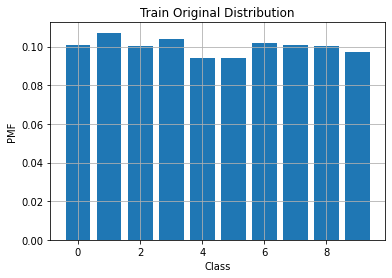

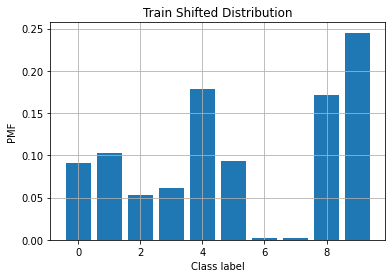

In [15]:
#train Distribution shift
plot(y_train, shifted_dist_idx)

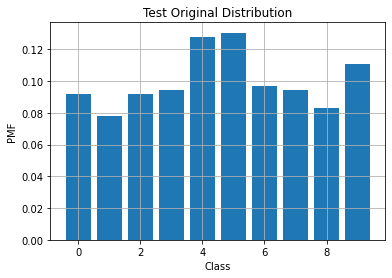

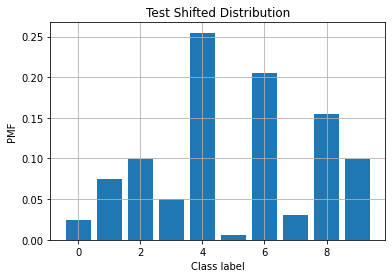

In [16]:
#test Distribution shift
plot(y_test, shifted_test_dist_idx, 'Test')

## Sync With Data

In [17]:
### No subsampling - take source Dist.
X_train, y_train = X_train[shifted_dist_idx], y_train[shifted_dist_idx]

### Shifting test distribution
X_test, y_test = X_test[shifted_test_dist_idx], y_test[shifted_test_dist_idx]

In [18]:
#Get source (train) and target (test) label distributions
dist_train = get_distribution(y_train)
dist_test  = get_distribution(y_test)

print(f"Train distribution : {y_train.shape}")
print(f"Test distribution : {y_test.shape}")

Train distribution : (571,)
Test distribution : (161,)


## Train Model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

In [20]:
##typecast to tensors
X_train = torch.DoubleTensor(X_train).to(device)
X_test = torch.DoubleTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [21]:
# implement backprop
loss_function = nn.CrossEntropyLoss()

In [22]:
def train(data, epochs=500, epsilon=1e-5, print_st=False):
    """
    Train the model.
    Assumes access to global variable: loss function
    """
    X_train, y_train = data #extract info
    
    start_time = time.time()
    losses = []

    model = Network().to(device) #load local model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    #gather accuracies
    train_accuracy = []
    test_accuracy = []
    
    for i in range(epochs):
        model.train() #set back to train
        y_pred = model(X_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss)
        
        ## training accuracy
        predictions = np.array(y_pred.argmax(axis=1), dtype=np.int16)
        score = accuracy_score(y_train, predictions)
        train_accuracy.append(score)
        
        ## test accuracy
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            predictions = np.array(y_pred.argmax(axis=1), dtype=np.int16)
            score = accuracy_score(y_test, predictions)
            test_accuracy.append(score)
        
        if loss.item() < epsilon:
            if print_st:
                print(f"Model Converged at epoch {i + 1}, loss = {loss.item()}")
            break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if print_st:
        print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")

    return model, losses, train_accuracy, test_accuracy

In [23]:
model_normal, cost, training_accuracy, test_accuracy = train((X_train, y_train), print_st=True)

Total training time (sec): 1.0117168426513672, loss - 0.0003222514354779838


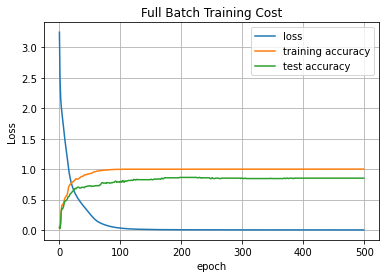

In [24]:
#graph cost
plt.plot(cost, label='loss')
plt.plot(training_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Full Batch Training Cost")
plt.legend()
plt.grid()
plt.show()

### Test Model

In [25]:
def predict(model):
    """ Predict accuracy => y_hat = f(x). """
    
    model.eval() #set to evaluation mode
    # predict X_test data
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X_test):
            y_pred = model(data)
            predictions.append(y_pred.argmax().item())

    predictions = np.array(predictions, dtype=np.int16)
    score = accuracy_score(y_test, predictions)
    return score, predictions

In [26]:
### Estimated distribution
score, predictions = predict(model_normal)
print(f"Test Accuracy : {score}")

Test Accuracy : 0.8509316770186336


# MALLS - Subsampling

<p> instead of directly going from imbalanced source to target using IW, let's convert the source to a more uniform distribution (medial distribution) and then compute the Label Shift + IW on that.</p>
<p> Creating uniform distribution from imbalanced dataset using <a href=''https://en.wikipedia.org/wiki/Probability_integral_transform>Probability integral transform</a> </p>

In [27]:
biased_probs = 1. / np.array(list(dist_train.values()))
biased_probs /= np.sum(biased_probs)

In [28]:
p = np.zeros(y_train.shape)

for i in range(len(p)):
    p[i] = biased_probs[y_train[i]]

p /= p.sum()

In [29]:
medial_idx = np.random.choice(np.arange(len(y_train)), size=y_train.shape, replace=True, p=p)

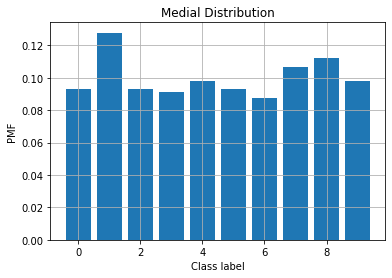

In [30]:
### Medial Distribution
plt.bar(x=np.unique(y_train[medial_idx]), height=get_distribution(y_train[medial_idx].numpy()).values())
plt.title("Medial Distribution")
plt.xlabel("Class label")
plt.ylabel("PMF")
plt.grid()
plt.show()

In [31]:
### Subsampling - take Medial Dist.
X_train, y_train = X_train[medial_idx], y_train[medial_idx]

# BSSE - Label Shift IW

In [32]:
delta = 1e-8 #0 < delta < 1/k where k = number of classes.
validation_ratio = 0.5

data = X_train.clone(), y_train.clone() #store original training distribution.

#Split training into training (source) and validation (hold-out)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_ratio, random_state=42)

In [33]:
### obtain classifier by training on X_train, y_train
f, cost, training_accuracy, test_accuracy = train((X_train, y_train), print_st=True)
### Estimated distribution
score, _ = predict(f)
print(f"No IW test score : {score}")

Total training time (sec): 0.8260931968688965, loss - 0.0001917707709788914
No IW test score : 0.9565217391304348


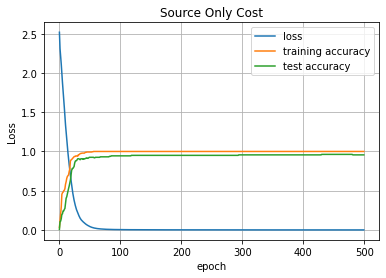

In [34]:
#graph cost
plt.plot(cost, label='loss')
plt.plot(training_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Source Only Cost")
plt.legend()
plt.grid()
plt.show()

## Generate Label Shift

In [35]:
def calculate_confusion_matrix(X, Y):
    """ 
    Calculates value for \hat{C}_{\hat{y}, y}
    @Params:
    - X : Validation data, i.e. X2
    - Y : Validation labels, i.e. Y2
    """
    k = len(np.unique(y)) #number of classes
    conf_matrx = np.zeros(shape=(k, k))
    #freeze params
    f.eval()
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X):
            y_pred = f(data)
            predictions.append(y_pred.argmax().item())
    
    predictions = np.array(predictions)
    for i in range(k):
        for j in range(k):    
            idxs = np.where((predictions == i) & (Y.numpy() == j))[0]
            conf_matrx[i, j] = float(len(idxs) / len(X))
    return conf_matrx, k

In [36]:
def calculate_target_priors(X, k):
    """ Calculates \hat{μ}_\hat{y} """
    preds = np.array([f(xp).argmax().item() for xp in X], np.int16)
    target_priors = np.zeros(k)
    for i in range(k):
        target_priors[i] = len(np.where(preds == i)[0]) / len(preds)
    return target_priors

In [37]:
conf_matrix, k = calculate_confusion_matrix(X_validation, y_validation)

In [38]:
mu = calculate_target_priors(X_test, k)

In [39]:
def compute_weights(cmf, target_priors):
    """ Computes label weights """
    w, _ = np.linalg.eig(cmf + np.random.uniform(0, 1e-3, size=cmf.shape))
    
    if abs(w.real.min()) <= delta: #non invertible matrix
        return np.full(shape=len(target_priors), fill_value=float(1 / len(target_priors)))
        
    
    try:
        label_weights = np.linalg.inv(cmf) @ mu
    except np.linalg.LinAlgError:
        label_weights = np.linalg.inv(cmf + np.random.uniform(0, 1e-3, size=cmf.shape)) @ target_priors
    
    label_weights = abs(label_weights)
    label_weights /= label_weights.sum()
    #label_weights[label_weights < 0] = 0 #strictly set rare occurances to 0 instead of abs (see BBSE)
    
    return label_weights

In [40]:
label_weights = compute_weights(conf_matrix, mu)

In [41]:
for lw in label_weights:
    print(float(lw), end=", ")
print(f"\n|w| = {np.linalg.norm(label_weights)}")

0.007581779925065469, 0.05502089063609477, 0.0937116784166715, 0.06616855010477055, 0.27762282777887914, 0.021293825050924836, 0.21843521523923445, 0.02670093778416191, 0.1724922060523485, 0.06097208901184891, 
|w| = 0.4191310524162318


## Importance Weights Training

In [42]:
def train_iw(X, y, network, epochs=500, print_st=True):
    """ Train model using class weights """
    
    start_time = time.time()
    m, k = len(X), len(np.unique(y))
    
    loss_function = nn.CrossEntropyLoss(weight=torch.DoubleTensor(label_weights))
    
    losses = []
    
    model = Network().to(device) #load local model
    
    cloned_params = {}

    for layer in network.state_dict():
        cloned_params[layer] = network.state_dict()[layer].clone()
    
    model.load_state_dict(cloned_params)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    
    #gather accuracies
    train_accuracy = []
    test_accuracy = []
    
    for i in range(epochs):
        
        model.train() #set back to train
        
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        losses.append(loss)
        
        ## training accuracy
        predictions = np.array(y_pred.argmax(axis=1), dtype=np.int16)
        score = accuracy_score(y, predictions)
        train_accuracy.append(score)
        
        ## test accuracy
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            predictions = np.array(y_pred.argmax(axis=1), dtype=np.int16)
            score = accuracy_score(y_test, predictions)
            test_accuracy.append(score)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if print_st:
        print(f"Total training time (sec): {time.time() - start_time}, loss - {loss.item()}")

    return model, losses, train_accuracy, test_accuracy

In [43]:
X_train, y_train = data #regain data

In [44]:
f_weighted, cost, training_accuracy, test_accuracy = train_iw(X_train, y_train, f)

Total training time (sec): 0.9690937995910645, loss - 0.00014679057603072022


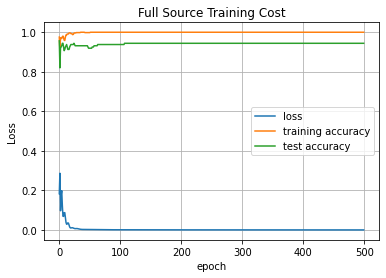

In [45]:
#graph cost
plt.plot(cost, label='loss')
plt.plot(training_accuracy, label='training accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Full Source Training Cost")
plt.legend()
plt.grid()
plt.show()

## Importance Weighting Test

In [46]:
def predict_IW(model):
    """ Predict accuracy => y_hat = f(x). Refer to BBSE, ICML '18 """
    
    model.eval() #set to evaluation mode
    predictions=[]
    with torch.no_grad():
        for i, data in enumerate(X_test):
            y_pred = model(data)
            y_pred *= label_weights #IW softmax
            
            predictions.append(y_pred.argmax().item())

    predictions = np.array(predictions, dtype=np.int16)
    score = accuracy_score(y_test, predictions)
    return score, predictions

In [47]:
### Prediction
score, _ = predict_IW(f_weighted)
print(f"IW test score : {score}")

IW test score : 0.9006211180124224


# MAML - Importance Weight Bias Reduction

In [48]:
### declare maml
maml = MAML(X_validation, y_validation, f_weighted, label_weights)

num_meta_updates = 2
for _ in range(num_meta_updates):
    maml.update()

In [49]:
label_weights = maml.get_label_weights()
print(f"Updated Weights : {label_weights} \n |w| = {np.linalg.norm(label_weights)}")

Updated Weights : [0.02758347 0.07501227 0.11369767 0.04616687 0.29762258 0.04129891
 0.23843501 0.04669691 0.19249243 0.0809733 ] 
 |w| = 0.463004207342887


### Run Predictions with updated weights

In [50]:
### Prediction
score, _ = predict_IW(f_weighted)
print(f"MAML + IW test score : {score}")

MAML + IW test score : 0.906832298136646
